In [3]:
#Import Libraries
import math 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense,Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import tensorflow as tf


In [4]:
#Importing data
def read_df(csv_file):
    df = pd.read_csv(csv_file)
    df["Date"]=pd.to_datetime(df["Date"])
    df.index=df["Date"]
    df.drop("Date",axis=1,inplace=True)
    df = df.filter(['Close'])
    return df
csv_file = "C:\\Users\\ACER\\Desktop\\Final Project\\final\\NABIL.csv"
df = read_df(csv_file)
df

,Close
Date,
2000-07-06,1300.0
2000-07-07,1325.0
2000-07-10,1340.0
2000-07-11,1340.0
2000-07-12,1356.0
...,...
2023-01-03,736.0
2023-01-04,736.9
2023-01-05,727.0


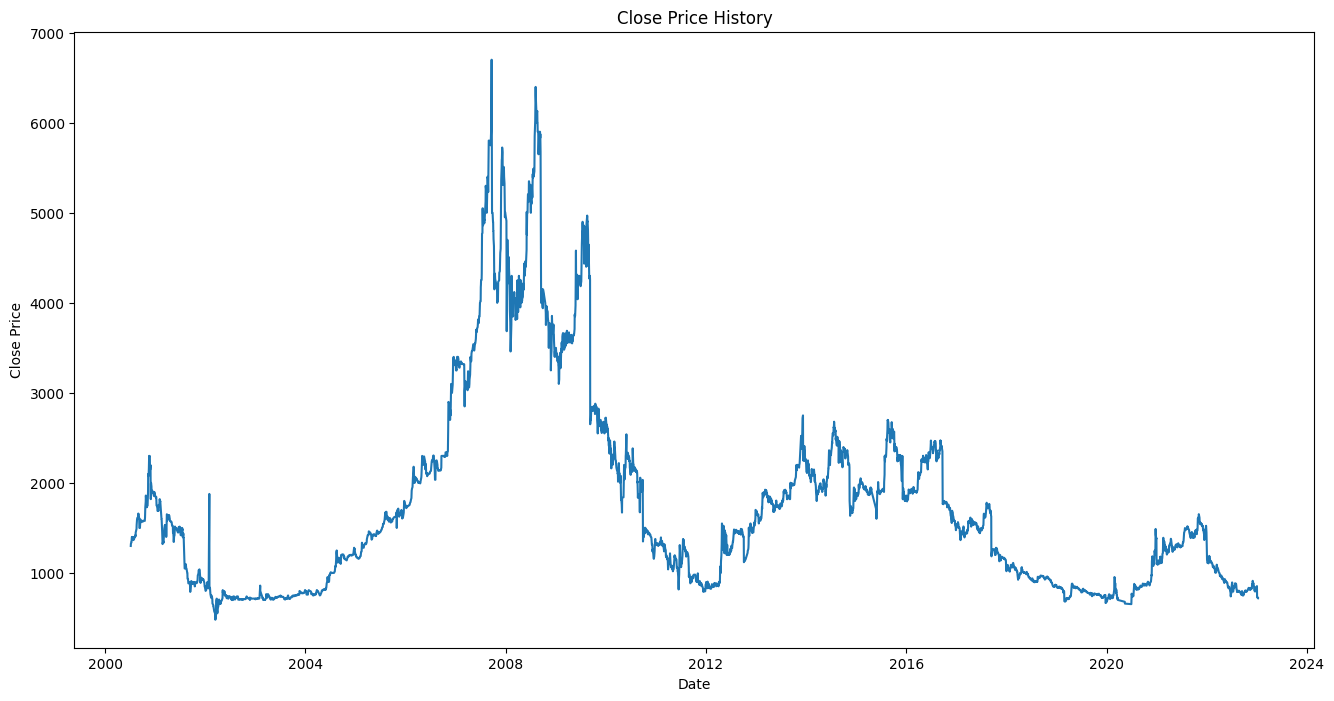

In [5]:
#Exploring Data
def plot_data(df):
    plt.figure(figsize=(16,8))
    plt.title("Close Price History")
    plt.plot(df['Close'])
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()
plot_data(df)

In [6]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.8)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df,split_index
train_data, test_data, split = train_test_split(df)
test_data

,Close
Date,
2018-04-12,988.0
2018-04-15,990.0
2018-04-16,996.0
2018-04-17,1002.0
2018-04-18,1040.0
...,...
2023-01-03,736.0
2023-01-04,736.9
2023-01-05,727.0


In [7]:
#Data Preprocessing
def preprocess_data(data):
    # Get the number of rows in the data
    nrows = data.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    
    return np_data_scaled, scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)

(3943, 1)
(1085, 1)


In [8]:
#Data Partition
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [9]:
# Generate training data and test data
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3843, 100, 1) (3843, 1)
(985, 100, 1) (985, 1)


In [10]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(units= 50, activation= 'relu', return_sequences= True, 
               input_shape= (x_train.shape[1], 1)))

model.add(Dropout(0.2))


model.add(LSTM(units= 60, activation= 'relu', return_sequences= True))

model.add(Dropout(0.3))


model.add(LSTM(units= 80, activation= 'relu', return_sequences= True))

model.add(Dropout(0.4))


model.add(LSTM(units= 120, activation= 'relu'))

model.add(Dropout(0.5))


model.add(Dense(units= 1))

model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# fit the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - loss: 0.0016 - val_loss: 0.0036


In [22]:
# prediction 
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
test_predict.shape

121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


(985, 1)

In [23]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))


In [36]:
Train = df[:split]
valid = df[split:]
valid['Predictions'] = test_predict
valid

C:\Users\ACER\AppData\Local\Temp\ipykernel_15544\925727386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict


,Close,Predictions
Date,,
2018-09-06,965.0,939.857605
2018-09-09,970.0,942.806824
2018-09-10,964.0,946.102356
2018-09-11,966.0,949.111755
2018-09-12,965.0,951.360596
...,...,...
2023-01-03,736.0,853.266724
2023-01-04,736.9,855.792969
2023-01-05,727.0,855.603699


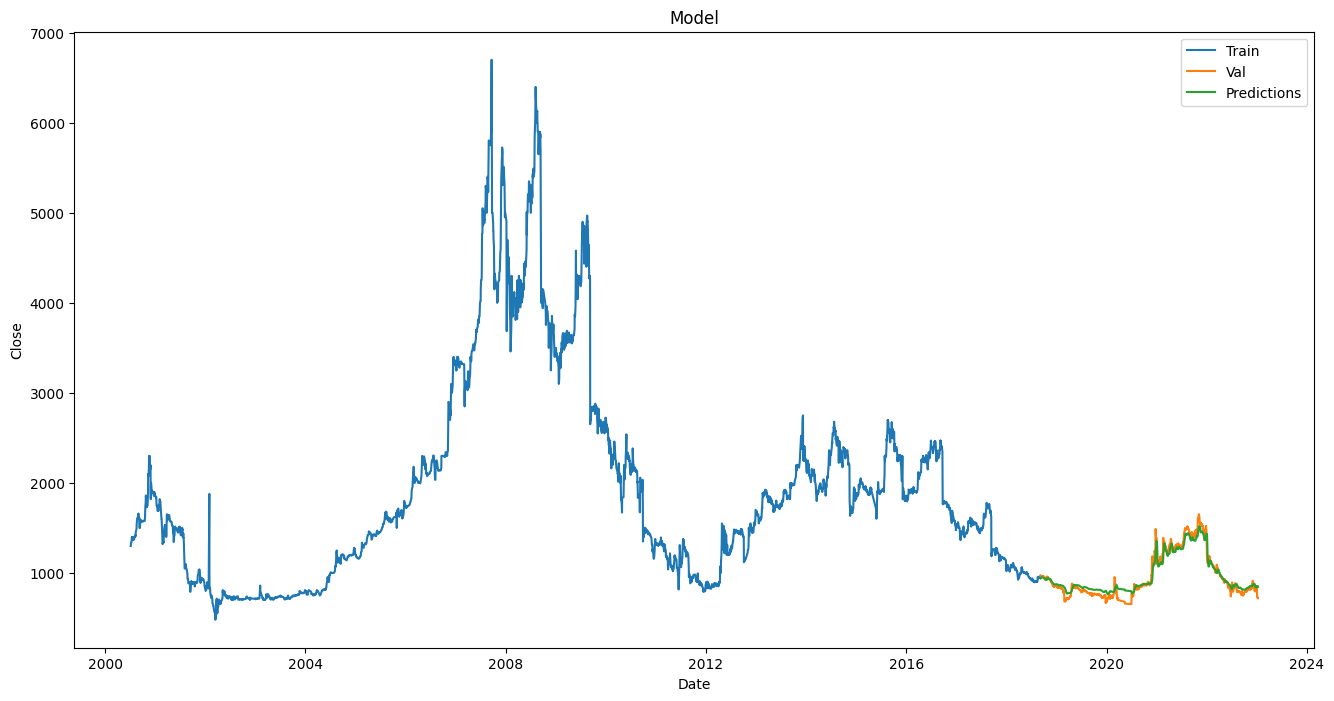

In [34]:
plt.figure(figsize=(16,8 ))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(Train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
 
plt.show()

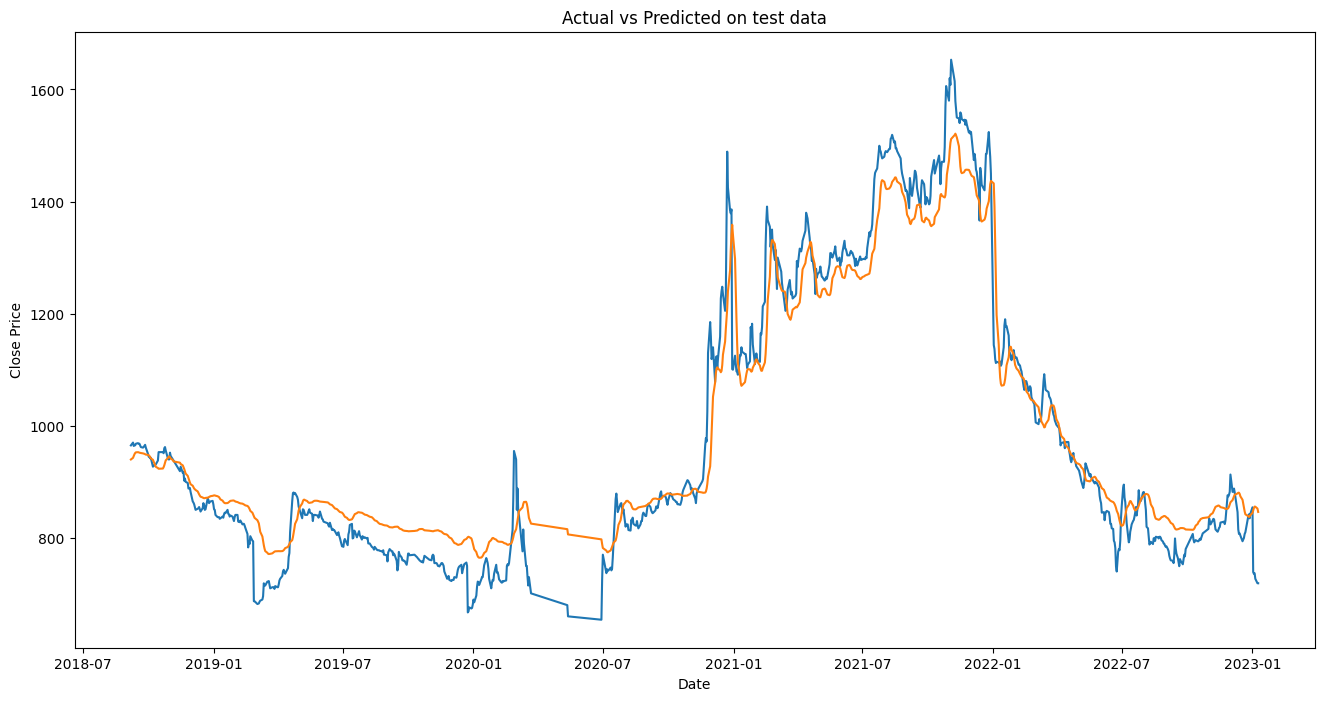

In [35]:
plt.figure(figsize=(16,8))
plt.title("Actual vs Predicted on test data")
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Use pandas to concatenate the forecasted values to the last of the dataset
forecasted_values = pd.DataFrame(lst_output, columns=['Close'])
forecasted_values = pd.(lst_output, columns=['Close'])
original_data_length = len(dataset)
index = pd.date_range(start=dataset.index[-1] + pd.DateOffset(1), periods=forecast, freq="D")
forecasted_values.set_index(index,inplace=True)
print(forecasted_values)
dataset = pd.concat([dataset, forecasted_values], axis=0)

plt.figure(figsize=(16,8))
plt.plot(dataset.index[-sequence_length-forecast:-forecast], dataset['Close'][-sequence_length-forecast:-forecast], 'b', label='Original')
plt.plot(dataset.index[-forecast:], dataset['Close'][-forecast:], 'orange', label='Forecasted Close')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Values')
plt.show()
